In [1]:
import os
import random
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ray
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from ray.tune.logger import TBXLoggerCallback
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.env import BaseEnv
from ray.rllib.evaluation import Episode, RolloutWorker
from ray.rllib.evaluation.episode_v2 import EpisodeV2
from ray.rllib.policy import Policy
import seaborn as sns
import torch

from stocktradingv2.agent.mydqn import MyDQNConfig, MyDQN
from stocktradingv2.env.SingleStockTradingEnv import SingleStockTradingEnv

c:\ProgramData\Miniconda3\envs\FTL\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ray.init()

2023-03-13 13:38:02,552	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
SEED = 114

TEST_START_DAY = '2017-01-01'
TRADE_START_DAY = '2020-01-01'

In [4]:
dfs = []
for root, dirs, files in os.walk("./datasets/CSI300/"):
    for file in files:
        path = os.path.join("./datasets/CSI300/", file)
        df = pd.read_csv(path)
        dfs.append((file, df))

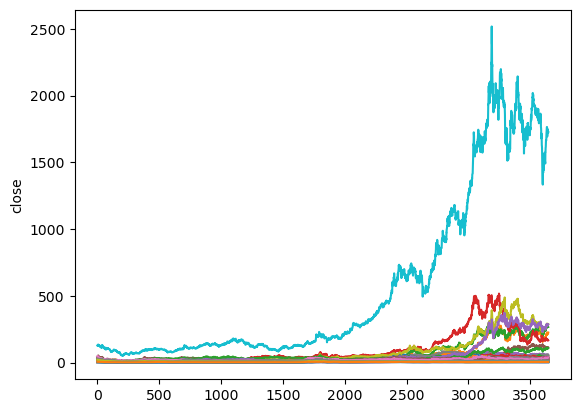

In [5]:
for tic, df in dfs:
    df.rename(columns={"close_": "close", "close": "close_"}, inplace=True)
    #print(np.log(df.close.iloc[-1]/df.close.iloc[0]))
    sns.lineplot(df.close)

In [6]:
test_start = pd.to_datetime(TEST_START_DAY, format='%Y-%m-%d')
trade_start = pd.to_datetime(TRADE_START_DAY, format='%Y-%m-%d')

dfs_train = []
dfs_test = []
dfs_trade = []
for tic, df in dfs:
    df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
    df_train = df.loc[df.date < test_start].sort_index(ascending=True).copy()
    df_test = df.loc[(df.date >= test_start) & (df.date < trade_start)].sort_index(ascending=True).copy()
    df_trade = df.loc[df.date >= trade_start].sort_index(ascending=True).copy()
    dfs_train.append(df_train)
    dfs_test.append(df_test)
    dfs_trade.append(df_trade)

In [7]:
class MyCallbacks(DefaultCallbacks):
    def __init__(self, legacy_callbacks_dict: Dict[str, callable] = None):
        self._eval_counter = 0
        self._train_counter = 0
        super().__init__(legacy_callbacks_dict)

    def on_episode_end(
        self,
        *,
        worker: RolloutWorker,
        base_env: BaseEnv,
        policies: Dict[str, Policy],
        episode: EpisodeV2,
        env_index: int,
        **kwargs
    ):
        env = base_env.get_sub_environments()[env_index]

        episode.custom_metrics["total_trading"] = env.total_trading
        episode.custom_metrics["success_rate"] = env.success_trade / env.total_trading
        episode.custom_metrics["log-ret"] = np.log(env.asset_memory[-1] / env.asset_memory[0])
        # episode.hist_data["action_memory"] = env.action_memory
        # episode.hist_data["asset_memory"] = env.asset_memory

        _plot = False
        if _plot:
            df = pd.DataFrame(
                data={
                "date": env.date,
                "prices": env.prices,
                "action": [1] + env.action_memory,
                "asset": env.asset_memory
                }
            )
            df.loc[df.action == 1, "action"] = np.nan
            fig, ax = plt.subplots()
            sns.lineplot(x=df.date, y=df.prices, ax=ax)
            # plot buying action
            sns.scatterplot(
                x=df.date[df.action == 0], 
                y=df.prices[df.action == 0],  
                markers="^", 
                ax=ax
            )
            # plot selling action
            sns.scatterplot(
                x=df.date[df.action == 2], 
                y=df.prices[df.action == 2], 
                markers="v",
                ax=ax
            )

            in_eval =  worker.policy_config["in_evaluation"]
            dqn_type = worker.policy_config["model"]["custom_model_config"] ["type"]
            df_num = len(env._dfs)
            if in_eval:
                fig.savefig(f"./eval_df{df_num}_{self._eval_counter}_{episode.episode_id:05d}.png")
                self._eval_counter += 1
            else:
                if self._train_counter % 10 == 0:
                    fig.savefig(f"./train_df{df_num}_{self._train_counter}_{episode.episode_id:05d}.png")
                self._train_counter += 1

In [8]:
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)

In [9]:
param_space = {
    "framework": "torch",
    "env": "SingleStockTrading",
    "disable_env_checking": True,
    "env_config": {
        "df": dfs_train,
        "num_df": tune.grid_search([min(i ** 2, len(dfs_train)) for i in range(1, 9)]),
        #"seed": SEED,
        #"shuffle": True,
    },

    "num_workers": 1,
    # "num_envs_per_worker": 10,
    # "num_cpus_per_worker": 1,

    "model": {
        "custom_model_config": {
            "type": "dqn", # tune.grid_search(["dqn", "iqn", "qrdqn", "cqn"]) ,
            "vmin": -10,
            "vmax": 10,
            "lstm_dim": 64,
            "net_arch": [64],
            "action_mask_fn": SingleStockTradingEnv.action_mask_fn,
            "num_atoms": 50,
            "cos_embedding_dim": 64,
            "risk_distortion_measure": None,
        }
    },
    #"seed": 114,
    "training_intensity": 25, #
    "train_batch_size": 64,
    #"min_sample_timesteps_per_iteration": 64,
    "min_train_timesteps_per_iteration": 64,
    
    "exploration_config": {
            "type": "EpsilonGreedy",
            "initial_epsilon": 1.0,
            "final_epsilon": 0.02,
            "epsilon_timesteps": 10000,
    },
    "callbacks": MyCallbacks,

    "evaluation_interval": 10,
    "evaluation_duration": len(dfs_test),
    "evaluation_duration_unit": "episodes",
    "evaluation_num_workers": 1,
    "evaluation_config": {
        "explore": False,
        "env_config": {
            "df": dfs_test,
            "num": len(dfs_test),
        },
    }
}

In [10]:
tuner = tune.Tuner(
    MyDQN, 
    param_space=param_space,
    tune_config=tune.TuneConfig(num_samples=1),
    run_config=air.RunConfig(
        name="MyDQN_dfs_train_try_to_fix_eval_and_more_steps",
        progress_reporter=JupyterNotebookReporter(),
        stop={
            "episode_reward_mean": 10,
            "timesteps_total": 150000,
        },
        callbacks=[TBXLoggerCallback()],
    )
)
results = tuner.fit()

(MyDQN pid=17812) 2023-03-13 13:38:22,593	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=17812) 2023-03-13 13:38:23,010	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MyDQN pid=640) 2023-03-13 13:38:41,485	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=640) 2023-03-13 13:38:41,903	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(MyDQN pid=356) 2023-03-13 13:39:01,447	WARNING algorithm_config.py:596 -- Cannot create MyDQNConfig from given `config_dict`! Property __stdout_file__ not supported.
(MyDQN pid=356) 2023-03-13 13:39:01,875	INFO algorithm.py:506 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / '

Trial name,agent_timesteps_total,connector_metrics,counters,custom_metrics,date,done,episode_len_mean,episode_media,episode_reward_max,episode_reward_mean,episode_reward_min,episodes_this_iter,episodes_total,experiment_id,hostname,info,iterations_since_restore,node_ip,num_agent_steps_sampled,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_this_iter,num_env_steps_trained,num_env_steps_trained_this_iter,num_faulty_episodes,num_healthy_workers,num_in_flight_async_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,pid,policy_reward_max,policy_reward_mean,policy_reward_min,sampler_perf,sampler_results,time_since_restore,time_this_iter_s,time_total_s,timers,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
MyDQN_SingleStockTrading_3c98d_00000,1000,{},"{'num_env_steps_sampled': 1000, 'num_env_steps_trained': 57600, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 57600, 'last_target_update_ts': 960, 'num_target_updates': 2}",{},2023-03-13_13-39-14,False,nan,{},nan,nan,nan,0,0,dcff6a71df2e40d8973d88cebeb631a9,LAPTOP-I039M4TT,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.003161016386002302, 'cur_lr': 0.0005, 'td_error': 0.00516668101772666, 'loss': 9.189655247610062e-05, 'mean_r_t': 0.003862338839098811}, 'td_error': array([ 0.03938447, 0.02018072, 0.03283558, 0.02901123, -0.03490195, -0.04746638, -0.10209908, 0.02186369, 0.05207647, -0.02291258, 0.03361569, -0.05623021, 0.05837402, 0.01410811, -0.04700665, -0.0464538 , -0.07480043, -0.01324043, 0.09884156, 0.01280383, -0.01068783, 0.00548512, -0.0211787 , 0.02151199, 0.00835368, 0.00725956, 0.00073354, 0.03976487, -0.01915336, -0.02221998, 0.02296479, -0.00262463, -0.03029069, -0.05500337, -0.02919208, 0.00624033, -0.0351904 , -0.00476079, 0.0280834 , -0.07150282, 0.06363913, 0.11772418, 0.01755945, -0.03660414, 0.01973456, 0.02050655, -0.04058438, 0.03694677, -0.02291258, 0.03104903, 0.03361569, -0.00199313, 0.02570728, 0.03782904, 0.04122473, 0.03116322, 0.01277471, 0.00142502, -0.01970418, -0.03587016, 0.03640118, 0.1037028 , -0.00058173, 0.05133803], dtype=float32), 'mean_td_error': 0.00516668101772666, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 64.0, 'num_grad_updates_lifetime': 900.0, 'diff_num_grad_updates_vs_sampler_policy': 899.0}}, 'num_env_steps_sampled': 1000, 'num_env_steps_trained': 57600, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 57600, 'last_target_update_ts': 960, 'num_target_updates': 2}",1,127.0.0.1,1000,57600,1000,1000,57600,57600,0,1,0,0,57600,"{'cpu_util_percent': 23.68421052631579, 'ram_util_percent': 77.33859649122806}",17812,{},{},{},{},"{'episode_reward_max': nan, 'episode_reward_min': nan, 'episode_reward_mean': nan, 'episode_len_mean': nan, 'episode_media': {}, 'episodes_this_iter': 0, 'policy_reward_min': {}, 'policy_reward_max': {}, 'policy_reward_mean': {}, 'custom_metrics': {}, 'hist_stats': {'episode_reward': [], 'episode_lengths': []}, 'sampler_perf': {}, 'num_faulty_episodes': 0, 'connector_metrics': {}}",40.9773,40.9773,40.9773,"{'training_iteration_time_ms': 51.389, 'load_time_ms': 0.902, 'load_throughput': 70935.853, 'learn_time_ms': 8.272, 'learn_throughput': 7736.628, 'synch_weights_time_ms': 1.405}",1678685954,0,1000,1,3c98d_00000,11.0171
MyDQN_SingleStockTrading_3c98d_00001,1000,{},"{'num_env_steps_sampled': 1000, 'num_env_steps_trained': 57600, 'num_agent_steps_sampled': 1000, 'num_agent_steps_trained': 57600, 'last_target_update_ts': 960, 'num_target_updates': 2}",{},2023-03-13_13-39-36,False,nan,{},nan,nan,nan,0,0,f8c26734b2d14c1fa9de3729168d3795,LAPTOP-I039M4TT,"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': 0.0019805345218628645, 'cur_lr': 0.0005, 'td_error': -0.004303142428398132, 'loss': 4.4212596549186856e-05, 'mean_r_t': 0.002175892936065793}, 'td_error': array([-0.09556839, -0.0102181 , -0.02259786, -0.02742443, 0.07407581, -

In [39]:
results[0].checkpoint

Checkpoint(local_path=C:\Users\Wu Lingfeng\ray_results\MyDQN_2023-03-11_17-54-04\MyDQN_SingleStockTrading_a8457_00000_0_type=dqn_2023-03-11_17-54-04\checkpoint_000079)

In [ ]:
result = results.get_best_result(metric="episode_reward_mean", mode="max")
cp = result.best_checkpoints[0][0]
algo = MyDQN.from_checkpoint(cp)